In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Label_Data.parse(Label_Data.sheet_names[1])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX', 'MATCH BASC2', 'INDEX GA', 'INDEX MEDU','HYP', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'HYP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(127, 152)
(127, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[8])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'HYP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['ATP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[5])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','HYP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(36, 152)
(36, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
data_features.head()

,148,149,150,151,152,153,154,155,156,157,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
2,0.451501,0.588321,0.256930,0.574458,0.516602,0.663916,0.209146,0.714051,0.671614,0.323157,...,0.323372,0.512417,0.284735,0.070483,0.190034,0.095532,1.0,0.750000,16.0,1.012329
7,0.692523,0.585123,0.432055,0.382984,0.503866,0.527308,0.696945,0.175122,0.557615,0.240789,...,0.365549,0.858954,0.585301,0.301865,0.196801,0.060151,0.0,0.500000,11.0,1.035616
8,0.491701,0.348008,0.236042,0.424063,0.384201,0.415209,0.481709,0.526832,0.485609,0.200656,...,0.295115,0.426270,0.357341,0.164576,0.039512,0.413664,1.0,0.333333,10.0,1.052055
13,0.319104,0.468101,0.336863,0.092164,0.381038,0.106916,0.390177,0.301916,0.249480,0.127686,...,0.144110,0.153669,0.139014,0.229038,0.001697,0.242134,0.0,0.750000,14.0,1.036986
14,0.654127,0.348902,-0.041692,0.359504,0.140687,0.271660,0.156659,0.387055,0.465791,0.265987,...,0.083210,0.306614,0.440261,0.148032,0.490252,0.501948,1.0,0.833333,12.0,1.058904


In [5]:
interpolated_data_features.head()

,148,149,150,151,152,153,154,155,156,157,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,0.562762,0.618661,0.495730,0.449952,0.536899,0.750833,0.543050,0.577169,0.566864,0.479414,...,0.312915,0.472853,0.676559,0.450678,0.691308,0.439727,1,0.750000,18.0,2
1,0.467423,0.631338,0.532232,0.460269,0.376783,0.666626,0.690089,0.528182,0.605732,0.444019,...,0.310613,0.599923,0.723777,0.366962,0.624225,0.430461,0,0.833333,16.0,2
2,0.445946,0.485258,0.461295,0.353590,0.470679,0.774489,0.518367,0.721257,0.575006,0.359908,...,0.232181,0.401224,0.440656,0.453038,0.697615,0.459404,0,0.833333,14.0,2
3,0.481493,0.601370,0.491801,0.440704,0.393892,0.626598,0.647973,0.572020,0.575481,0.288114,...,0.266730,0.572110,0.705704,0.639587,0.615286,0.546791,1,0.833333,12.0,2
4,0.331614,0.455956,0.421249,0.210798,0.313205,0.440197,0.366279,0.481840,0.417571,0.202204,...,0.237554,0.335338,0.489976,0.260742,0.548064,0.284220,0,0.583333,14.0,2


In [6]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(190, 152)
(190, 152)
(190, 152)
(190, 152)
(190, 152)
(192, 152)
(192, 152)
(192, 152)


In [7]:
training_indices_X[0].head()

,148,149,150,151,152,153,154,155,156,157,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,0.747789,0.470094,0.174162,0.807876,0.279312,0.581647,0.915961,0.203061,0.424740,0.507834,...,0.334543,0.743217,0.229896,0.115003,0.613862,0.419573,0.0,0.916667,14.0,1.161644
1,0.670796,0.623289,0.232062,0.470455,0.275262,0.860769,0.429515,0.461276,0.593494,0.172633,...,0.216634,0.271318,0.347661,0.134042,0.413723,0.255445,1.0,0.750000,9.0,1.024658
2,0.369494,0.236757,0.265478,0.508863,0.309049,0.528306,0.228731,0.558664,0.453777,0.085329,...,0.226022,0.419697,0.351481,0.487143,0.186957,0.223046,1.0,0.833333,10.0,0.972603
3,0.355817,0.350438,0.188751,0.190080,0.362744,0.260105,0.239119,0.118580,0.415098,0.113200,...,0.109657,0.128430,0.526648,0.083436,0.535189,0.444251,0.0,0.500000,14.0,1.008219
4,0.369408,0.504562,0.212698,0.244631,0.275085,0.323141,0.513782,0.165660,0.291562,0.251936,...,0.144029,0.241537,0.264994,0.284063,0.312178,0.391243,0.0,0.666667,19.0,1.015068


In [8]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(190, 152)
(190, 152)
(190, 152)
(190, 152)
(190, 152)
(192, 152)
(192, 152)
(192, 152)
----------
(226, 152)
(226, 152)
(226, 152)
(226, 152)
(226, 152)
(228, 152)
(228, 152)
(228, 152)
Label shapes
(190, 1)
(190, 1)
(190, 1)
(190, 1)
(190, 1)
(192, 1)
(192, 1)
(192, 1)
----------
(226, 1)
(226, 1)
(226, 1)
(226, 1)
(226, 1)
(228, 1)
(228, 1)
(228, 1)


In [9]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [10]:
testing_fold_Y_1.shape

(16, 1)

In [11]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.796844 using {'batch_size': 30, 'dropout': 0.1, 'epochs': 25, 'layer1_size': 90, 'layer2_size': 35}
D_in, H1, H2, D_out = 152, 90, 35, 1
EPOCHS = 25
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.10

test_size = 19
test_size1 = 18

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [12]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(16, 152)
(16, 152)
(16, 152)
(16, 152)
(16, 152)
(16, 152)
(16, 152)
(15, 152)


In [13]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [14]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model.train()
print(model)
#weights = torch.FloatTensor([5]) #Class weights?
#criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model1.train()
#print(model)
#weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model2.train()
#print(model)
#weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model3.train()
#print(model)
#weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model4.train()
#print(model)
#weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model5.train()
#print(model)
#weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss()
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model6.train()
#print(model)
#weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss()
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_atp_sa_only_2y.pth'))
model7.train()
#print(model)
#weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss()
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=152, out_features=90, bias=True)
  (layer_2): Linear(in_features=90, out_features=35, bias=True)
  (layer_out): Linear(in_features=35, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [15]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.09345 | Acc: 59.250
Validation Accuracy |  50.0  PPV |  [0.875 0.125]  Recall |  [0.5 0.5]
Training Epoch 002: | Loss: 0.79711 | Acc: 54.750
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 003: | Loss: 0.74509 | Acc: 50.000
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 004: | Loss: 0.69523 | Acc: 52.875
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 005: | Loss: 0.68764 | Acc: 53.625
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 006: | Loss: 0.67998 | Acc: 53.625
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 007: | Loss: 0.67213 | Acc: 57.875
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Train

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 014: | Loss: 0.62940 | Acc: 61.125
Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]
Training Epoch 015: | Loss: 0.61201 | Acc: 68.500
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 016: | Loss: 0.60337 | Acc: 71.000
Validation Accuracy |  62.5  PPV |  [0.9        0.16666667]  Recall |  [0.64285714 0.5       ]
Training Epoch 017: | Loss: 0.59731 | Acc: 70.250
Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]
Training Epoch 018: | Loss: 0.58672 | Acc: 73.375
Validation Accuracy |  62.5  PPV |  [0.9        0.16666667]  Recall |  [0.64285714 0.5       ]
Training Epoch 019: | Loss: 0.58114 | Acc: 73.125
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 020: | Loss: 0.56844 | Acc: 75.000
Validation Accuracy |  68.75  PPV |  [0.90909091 0.2       ]  Recall |  [0.714

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.08156 | Acc: 59.875
Validation Accuracy |  50.0  PPV |  [0.8 0. ]  Recall |  [0.57142857 0.        ]
Training Epoch 002: | Loss: 0.86525 | Acc: 47.125
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 003: | Loss: 0.73116 | Acc: 50.875
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 004: | Loss: 0.70288 | Acc: 51.375
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 005: | Loss: 0.67994 | Acc: 56.375
Validation Accuracy |  93.75  PPV |  [0.93333333 1.        ]  Recall |  [1.  0.5]
Training Epoch 006: | Loss: 0.66376 | Acc: 53.375
Validation Accuracy |  93.75  PPV |  [0.93333333 1.        ]  Recall |  [1.  0.5]
Training Epoch 007: | Loss: 0.65704 | Acc: 58.125
Validation Accuracy |  93.75  PPV |  [0.93333333 1.        ]  Recall |  [1.  0.5]
Training Epoch 008: | Loss: 0.65432

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.32183 | Acc: 49.625
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 002: | Loss: 0.95113 | Acc: 55.500
Validation Accuracy |  68.75  PPV |  [0.90909091 0.2       ]  Recall |  [0.71428571 0.5       ]
Training Epoch 003: | Loss: 0.81122 | Acc: 50.000
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 004: | Loss: 0.74152 | Acc: 50.500
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 005: | Loss: 0.70105 | Acc: 49.375
Validation Accuracy |  93.75  PPV |  [0.93333333 1.        ]  Recall |  [1.  0.5]
Training Epoch 006: | Loss: 0.67458 | Acc: 58.500

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]
Training Epoch 007: | Loss: 0.67627 | Acc: 57.625
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 008: | Loss: 0.66061 | Acc: 61.125
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 009: | Loss: 0.65587 | Acc: 59.125
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 010: | Loss: 0.64950 | Acc: 63.125
Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]
Training Epoch 011: | Loss: 0.64536 | Acc: 63.250
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 012: | Loss: 0.65338 | Acc: 64.375
Validation Accuracy |  62.5  PPV |  [0.9        0.16666667]  Recall |  [0.64285714 0.5       ]
Training Epoch 013: | Loss: 0.63

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.13904 | Acc: 56.375
Validation Accuracy |  50.0  PPV |  [1.  0.2]  Recall |  [0.42857143 1.        ]
Training Epoch 002: | Loss: 0.87357 | Acc: 55.625
Validation Accuracy |  68.75  PPV |  [1.         0.28571429]  Recall |  [0.64285714 1.        ]
Training Epoch 003: | Loss: 0.76933 | Acc: 48.875
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 004: | Loss: 0.70050 | Acc: 52.375
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 005: | Loss: 0.67770 | Acc: 52.750
Validation Accuracy |  87.5  PPV |  [0.875 0.   ]  Recall |  [1. 0.]
Training Epoch 006: | Loss: 0.66856 | Acc: 55.875
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 007: | Loss: 0.65387 | Acc: 64.500
Validation Accuracy |  87.5  PPV |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.92857143 0.5       ]  Recall |  [0.92857143 0.5       ]
Training Epoch 008: | Loss: 0.66109 | Acc: 63.125
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 009: | Loss: 0.64540 | Acc: 63.875
Validation Accuracy |  87.5  PPV |  [0.92857143 0.5       ]  Recall |  [0.92857143 0.5       ]
Training Epoch 010: | Loss: 0.63376 | Acc: 65.250
Validation Accuracy |  87.5  PPV |  [0.92857143 0.5       ]  Recall |  [0.92857143 0.5       ]
Training Epoch 011: | Loss: 0.63593 | Acc: 66.500
Validation Accuracy |  87.5  PPV |  [0.92857143 0.5       ]  Recall |  [0.92857143 0.5       ]
Training Epoch 012: | Loss: 0.61919 | Acc: 66.125
Validation Accuracy |  87.5  PPV |  [0.92857143 0.5       ]  Recall |  [0.92857143 0.5       ]
Training Epoch 013: | Loss: 0.61109 | Acc: 66.375
Validation Accuracy |  87.5  PPV |  [0.92857143 0.5       ]  Recall |  [0.92857143 0.5       ]
Training Epoch 014: | Loss: 0.61332 | Acc: 68.000
Validation Accuracy 

In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.01812 | Acc: 60.750
Validation Accuracy |  56.25  PPV |  [0.81818182 0.        ]  Recall |  [0.64285714 0.        ]
Training Epoch 002: | Loss: 0.79016 | Acc: 54.625
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 003: | Loss: 0.71592 | Acc: 53.375
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 004: | Loss: 0.67587 | Acc: 52.750
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 005: | Loss: 0.65527 | Acc: 54.500
Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]
Training Epoch 006: | Loss: 0.65301 | Acc: 58.000
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 007: | Loss: 0.64598 | Acc: 63.500
Validation Accuracy |  62.5  PPV |  [0.83333333 0.        ]  Recall |  [0.71

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.19454 | Acc: 53.250
Validation Accuracy |  50.0  PPV |  [0.77777778 0.14285714]  Recall |  [0.53846154 0.33333333]
Training Epoch 002: | Loss: 0.82764 | Acc: 53.375
Validation Accuracy |  50.0  PPV |  [0.77777778 0.14285714]  Recall |  [0.53846154 0.33333333]
Training Epoch 003: | Loss: 0.71541 | Acc: 55.875
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 004: | Loss: 0.70087 | Acc: 51.750
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 005: | Loss: 0.67957 | Acc: 57.250
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 006: | Loss: 0.67301 | Acc: 65.875
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 007: | Loss: 0.65866 | Acc: 66.250
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 008: | Loss: 0.65885 | Acc: 57.250
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 009: | Loss: 0.64727 | Acc: 67.250
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 010: | Loss: 0.63913 | Acc: 67.375
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 011: | Loss: 0.63481 | Acc: 64.250
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 012: | Loss: 0.62532 | Acc: 67.250
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 013: | Loss: 0.60502 | Acc: 71.125
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 014: | Loss: 0.60532 | Acc: 69.375
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training

In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.40743 | Acc: 49.250
Validation Accuracy |  62.5  PPV |  [1.         0.33333333]  Recall |  [0.53846154 1.        ]
Training Epoch 002: | Loss: 1.00423 | Acc: 48.000
Validation Accuracy |  50.0  PPV |  [0.85714286 0.22222222]  Recall |  [0.46153846 0.66666667]
Training Epoch 003: | Loss: 0.81161 | Acc: 52.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 004: | Loss: 0.73244 | Acc: 48.375
Validation Accuracy |  87.5  PPV |  [0.86666667 1.        ]  Recall |  [1.         0.33333333]
Training Epoch 005: | Loss: 0.68489 | Acc: 53.500
Validation Accuracy |  87.5  PPV |  [0.86666667 1.        ]  Recall |  [1.         0.33333333]
Training Epoch 006: | Loss: 0.67285 | Acc: 55.375
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 0.66961 | Acc: 63.500
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 008: | Loss: 0.66710 | Acc: 60.000
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 009: | Loss: 0.65987 | Acc: 62.125
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 010: | Loss: 0.64513 | Acc: 65.875
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 011: | Loss: 0.64275 | Acc: 68.750
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 012: | Loss: 0.63011 | Acc: 72.250
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 013: | Loss: 0.63436 | Acc: 69.250
Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 014: | Loss: 0.62825 | 

In [23]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.17480 | Acc: 57.875
Validation Accuracy |  26.666666666666668  PPV |  [0.75       0.09090909]  Recall |  [0.23076923 0.5       ]
Training Epoch 002: | Loss: 0.97869 | Acc: 57.500
Validation Accuracy |  40.0  PPV |  [0.83333333 0.11111111]  Recall |  [0.38461538 0.5       ]
Training Epoch 003: | Loss: 0.81070 | Acc: 50.625
Validation Accuracy |  73.33333333333333  PPV |  [0.84615385 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 004: | Loss: 0.73628 | Acc: 50.875
Validation Accuracy |  73.33333333333333  PPV |  [0.84615385 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 005: | Loss: 0.69129 | Acc: 54.125
Validation Accuracy |  73.33333333333333  PPV |  [0.84615385 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 006: | Loss: 0.68597 | Acc: 52.125
Validation Accuracy |  80.0  PPV |  [0.85714286 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 007: | Loss: 0.67614 | Acc: 54.500
Validation Accuracy |  80.0

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 011: | Loss: 0.65435 | Acc: 63.750
Validation Accuracy |  66.66666666666666  PPV |  [0.9 0.2]  Recall |  [0.69230769 0.5       ]
Training Epoch 012: | Loss: 0.64945 | Acc: 62.375
Validation Accuracy |  66.66666666666666  PPV |  [0.83333333 0.        ]  Recall |  [0.76923077 0.        ]
Training Epoch 013: | Loss: 0.64139 | Acc: 63.375
Validation Accuracy |  80.0  PPV |  [0.85714286 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 014: | Loss: 0.63669 | Acc: 67.250
Validation Accuracy |  66.66666666666666  PPV |  [0.83333333 0.        ]  Recall |  [0.76923077 0.        ]
Training Epoch 015: | Loss: 0.62570 | Acc: 67.625
Validation Accuracy |  80.0  PPV |  [0.85714286 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 016: | Loss: 0.61169 | Acc: 66.625
Validation Accuracy |  80.0  PPV |  [0.85714286 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 017: | Loss: 0.60741 | Acc: 68.375
Validation Accuracy |  73.33333333333333  PPV |  [0.846

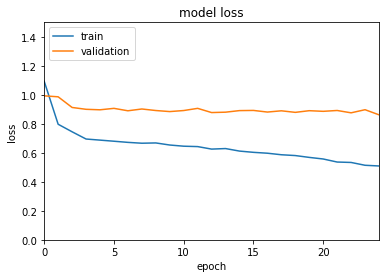

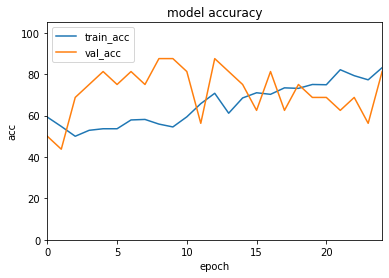

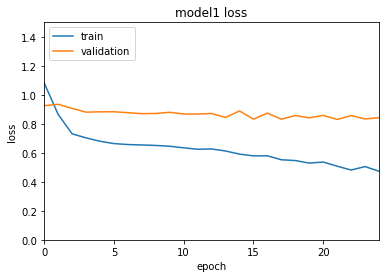

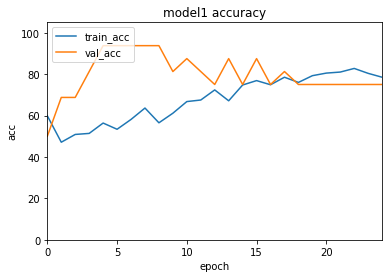

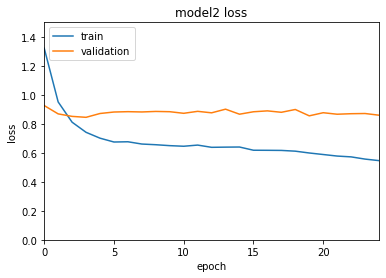

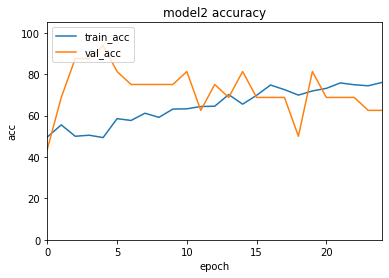

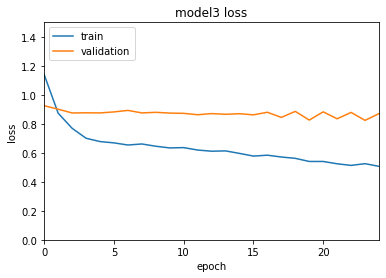

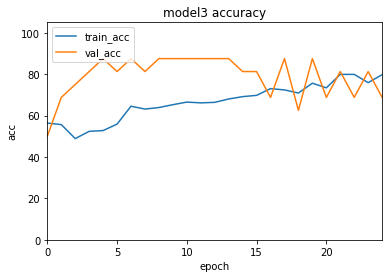

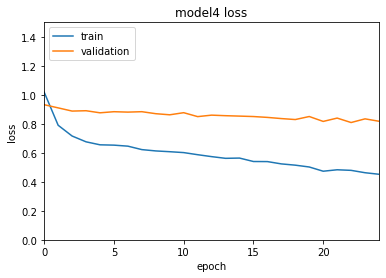

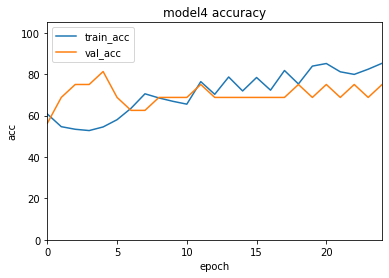

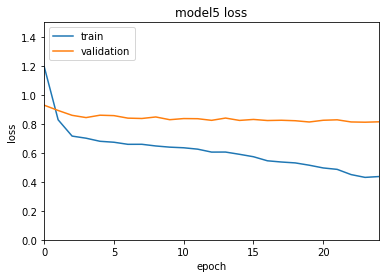

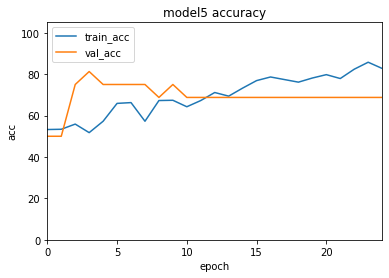

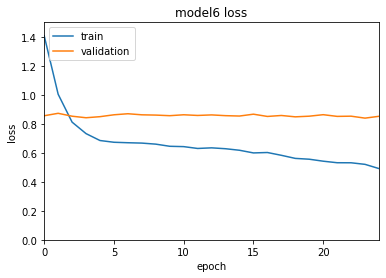

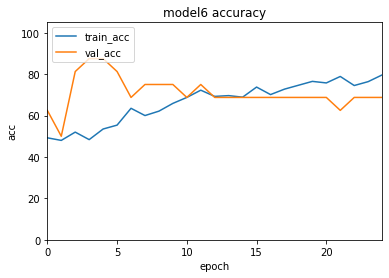

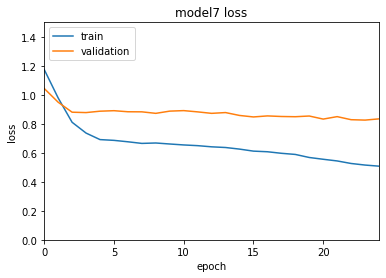

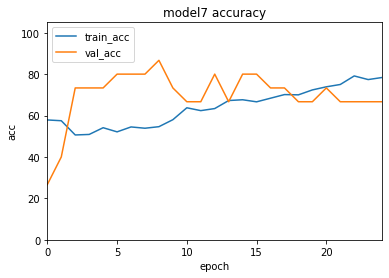

In [24]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]


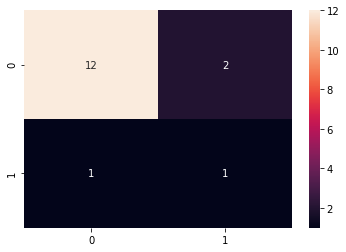

In [25]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [1.         0.33333333]  Recall |  [0.71428571 1.        ]


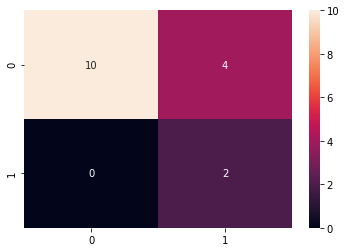

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  62.5  PPV |  [0.83333333 0.        ]  Recall |  [0.71428571 0.        ]


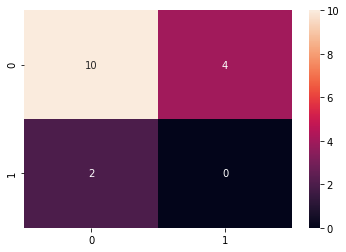

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  68.75  PPV |  [0.90909091 0.2       ]  Recall |  [0.71428571 0.5       ]


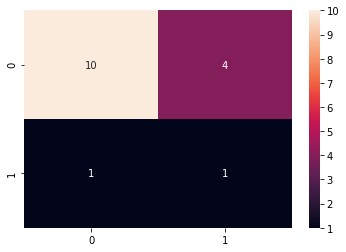

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]


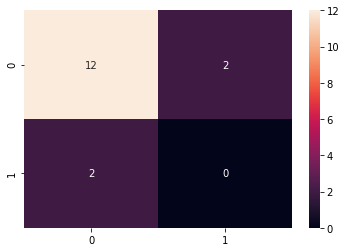

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  68.75  PPV |  [0.78571429 0.        ]  Recall |  [0.84615385 0.        ]


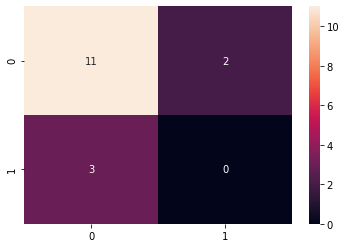

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  68.75  PPV |  [0.83333333 0.25      ]  Recall |  [0.76923077 0.33333333]


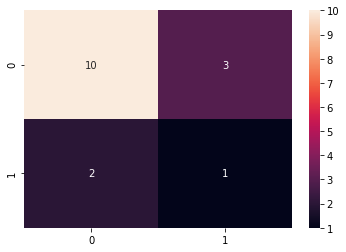

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  66.66666666666666  PPV |  [0.83333333 0.        ]  Recall |  [0.76923077 0.        ]


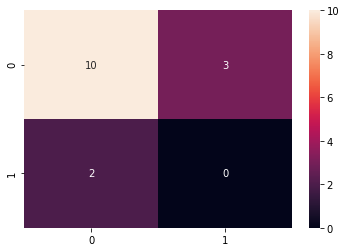

In [32]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [33]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[85 24]
 [13  5]]
Positive Predictive Value tp/(tp+fp):  0.1724137931034483
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.7086614173228346
Recall Value tp/(tp+fn):  0.2777777777777778


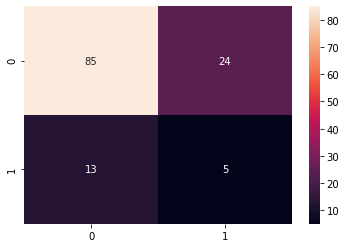

In [34]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 